# Wiener process on the sphere

We study the problem of generating uniformly distributed points on the sphere in 3D. This requires a little thought since the metric tensor corresponding to polar coordinates is non-trivial, so just drawing uniform angles will not do.
As a related problem, we study the generation of the Wiener process on the sphere. This is a problem involving "multiplicative noise", and hence the formulation of the SDE in Ito calculus is required.

## Setup

Some python setup: import the standard modules needed, setup the random-number generator, and provide some helper functions to map from spherical to Cartesian coordinates as well as to draw a sphere (used as a reference in the plots below).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
import time
import itertools

In [3]:
rng = np.random.default_rng()

In [4]:
def to_cartesian (r,phi,theta):
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(theta)
    return x,y,z

In [5]:
def draw_sphere(ax):
    u,v = np.mgrid[0:2*np.pi:50j,0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x,y,z, color='blue',alpha=0.3)

## Uniform Points on the Sphere

We include a method that is wrong, for illustrative purposes: just drawing both angles uniformly will not do. If you plot the result, you should see an accumulation of points near the poles of the spherical coordinate system.

In [6]:
def draw_uniform_angles(num):
    r = rng.choice([-1,1],num)
    phi = rng.random(num)*np.pi
    theta = rng.random(num)*np.pi
    x,y,z = to_cartesian(r,phi,theta)
    return x,y,z

The first method that works, is to apply the transformation involving the metric tensor correctly:

In [7]:
def draw_nonuniform_angles(num):
    r = rng.choice([-1,1],num)
    phi = rng.random(num)*np.pi
    theta = 2*np.arcsin(np.sqrt(rng.random(num)))
    x,y,z = to_cartesian(r,phi,theta)
    return x,y,z

Another method is to draw all Cartesian coordinates as Gaussian, and normalize the resulting vector to be of unit length. This is easily generalized to higher dimensions.
(This here is a rather clumsy implementation that is supposed to make clearer what happens by drawing x, y, and z separately. See below for a more compact python way to implement the same.)

In [8]:
def draw_gaussian(num):
    x = rng.standard_normal(num)
    y = rng.standard_normal(num)
    z = rng.standard_normal(num)
    v = np.stack([x,y,z]).T
    v = v / (np.linalg.norm(v,axis=1).reshape((-1,1)))
    return v[:,0],v[:,1],v[:,2]

One could also draw points in the unit cube (avoiding the generation of Gaussian-distributed random numbers) and normalize those to unit vectors. Then one has to discard any vectors that initially are longer than the unit vector because one draws too many samples near the corners of the unit cube.

In [14]:
def draw_discard(num):
    x = rng.random(num)*2-1
    y = rng.random(num)*2-1
    z = rng.random(num)*2-1
    v = np.stack([x,y,z]).T
    n = np.linalg.norm(v,axis=1)
    # first diving all and then selecting...
    v = v/n.reshape((-1,1))
    v = v[n<=1]
    # is actually somewhat faster than selecting twice
    #v = v[n<=1] / n[n<=1].reshape((-1,1))
    return v[:,0],v[:,1],v[:,2]

Try one of the methods and check the result:

In [10]:
x,y,z = draw_gaussian(1000)

<IPython.core.display.Javascript object>


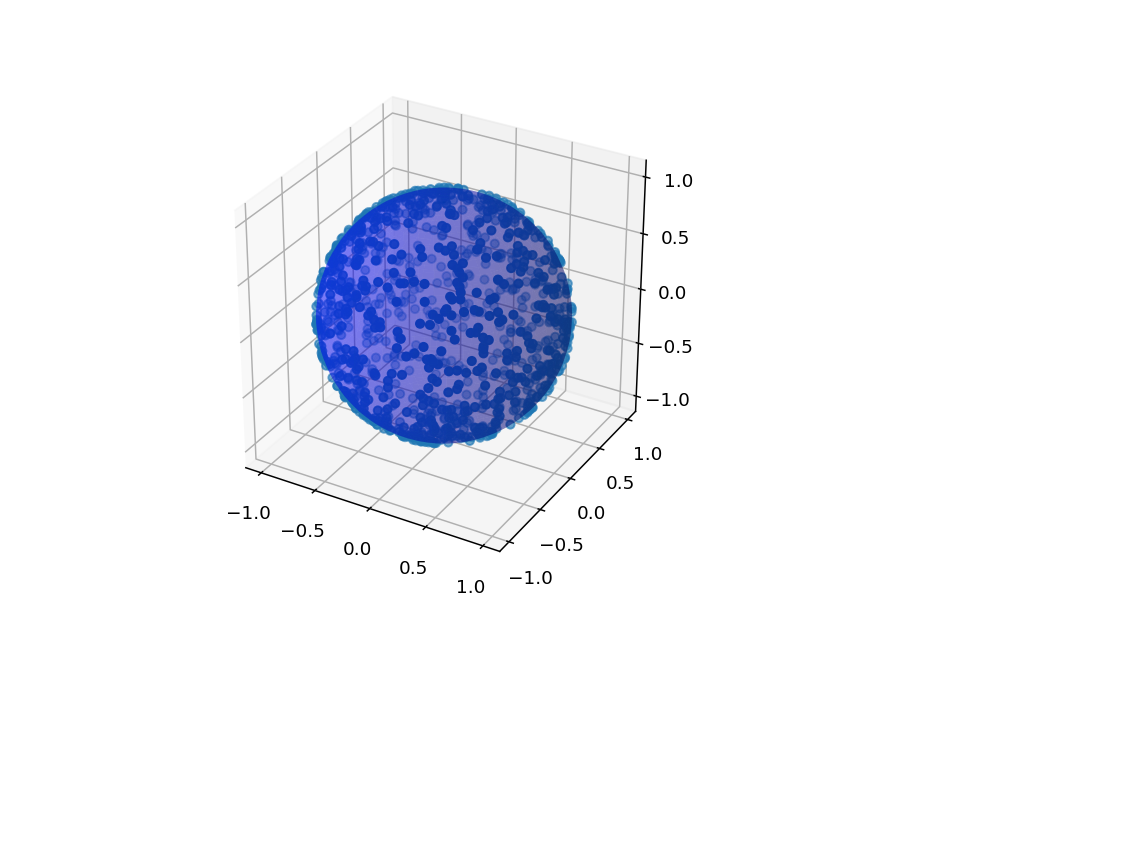

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d',box_aspect=(1,1,1))
draw_sphere(ax)
ax.scatter(x,y,z)

Let's do some performance checks: as it turns out, the Gaussian method is a clear winner at least in this implementation. It is only slightly slower than the discard method, and returns as many valid points as requested. (Although performance might depend on the implementation of the Gaussian rng.)

In [15]:
num = 10000000
for method in [draw_nonuniform_angles,draw_gaussian,draw_discard]:
    tic = time.perf_counter()
    x,y,z = method(num)
    toc = time.perf_counter()
    print ("method {m} took {t:0.4f} seconds, returned {n} points ({p:3.2f}%)".format(t=toc-tic,m=method.__name__,n=len(x),p=100*len(x)/num))
    x=y=z=None

method draw_nonuniform_angles took 0.8795 seconds, returned 10000000 points (100.00%)
method draw_gaussian took 0.4927 seconds, returned 10000000 points (100.00%)
method draw_discard took 0.4187 seconds, returned 5235737 points (52.36%)


Let's check the performance of the Gaussian and discard methods in higher dimensions. Here are implementations that work with adjustable dimensionality, and also happen to be more compact for the d=3 case:

In [16]:
def draw_gaussian_d(num,dim=3):
    cartesian = rng.standard_normal((num,dim))
    return (cartesian/np.linalg.norm(cartesian,axis=1).reshape((-1,1))).T
def draw_discard_d(num,dim=3):
    cartesian = rng.random((num,dim))*2-1
    n = np.linalg.norm(cartesian,axis=1)
    cartesian = cartesian / n.reshape((-1,1))
    v = cartesian[n<1]
    return v.T

We plot the executing time for a fixed number of attempts, and the success rate as a function of dimensionality. The execution time is linear in d, which is expected. The prefactor for the Gaussian method is indeed higher, because drawing Gaussian random numbers involves more computation than drawing uniform ones. (It looks like it is a bit worse than twice as much.) But of course, the success rate goes down much more rapidly (exponentially I believe), so that the execution time per successful point (shown as a dashed line) is infeasibly large for the discard method.

In [17]:
num = 100000
timing = {}
for method in [draw_gaussian_d,draw_discard_d]:
    timing[method.__name__]=[]
    for dim in range(1,15):
        tic = time.perf_counter()
        x = method(num,dim)
        toc = time.perf_counter()
        p = len(x.T)/num
        timing[method.__name__].append([dim,toc-tic,p])
        #print ("method {m} took {t:0.4f} seconds, returned {n} points ({p:3.2f}%)".format(t=toc-tic,m=method.__name__,n=len(x.T),p=100*len(x.T)/num))
        x=y=z=None
    timing[method.__name__]=np.array(timing[method.__name__])

<IPython.core.display.Javascript object>


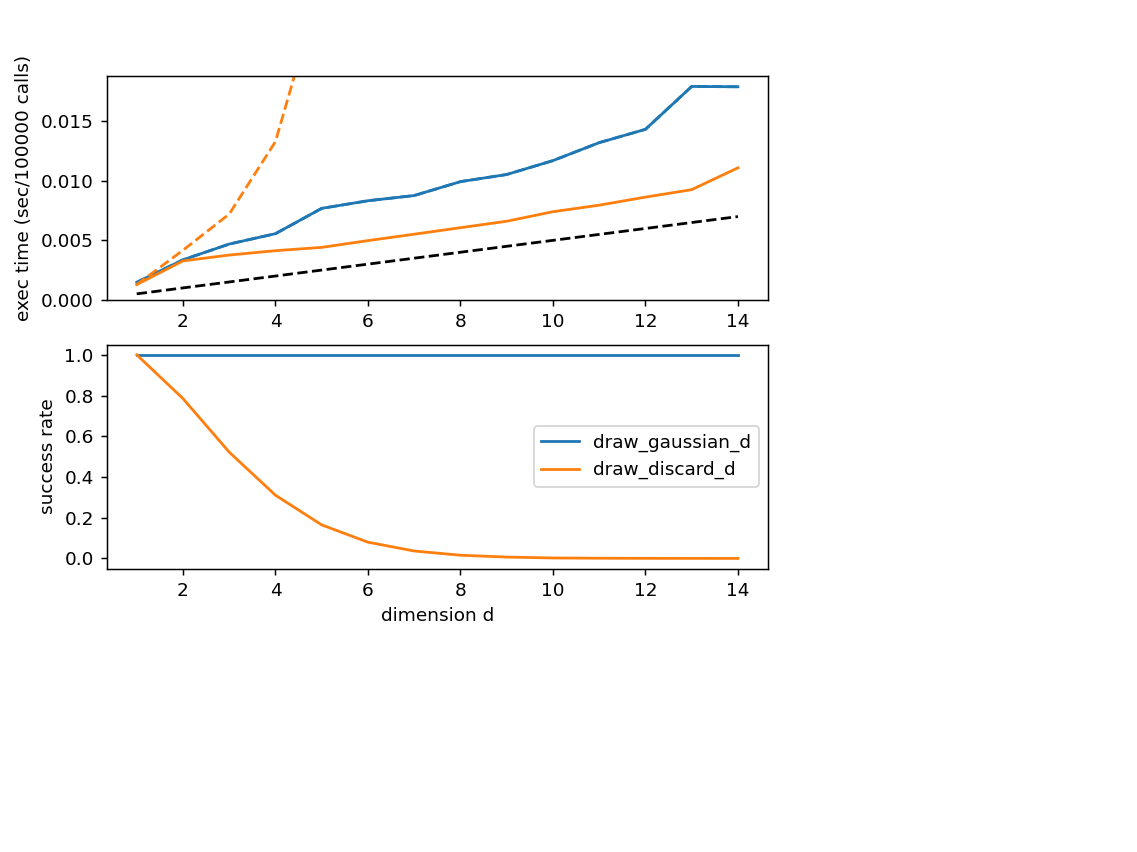

In [18]:
fig,ax = plt.subplots(2,1)
colors=itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
maxy=0
for method in [draw_gaussian_d,draw_discard_d]:
    name = method.__name__
    xr = timing[name][:,0]
    maxy = np.max([maxy,np.max(timing[name][:,1])])
    col = next(colors)
    ax[0].plot(xr,timing[name][:,1],label=name,color=col)
    ax[0].plot(xr,timing[name][:,1]/timing[name][:,2],linestyle='dashed',color=col)
    ax[1].plot(xr,timing[name][:,2],label=name)
ax[0].plot(xr,0.0005*xr,color='black',linestyle='dashed')
ax[0].set_ylabel('exec time (sec/{} calls)'.format(num))
ax[1].set_ylabel('success rate')
ax[1].set_xlabel('dimension d')
ax[0].set_ylim([0,maxy*1.05])
plt.legend()
plt.show()

## Random Walk on the Sphere

The following are simple minded python implementations to generate a random walk on the sphere (in d=3). The first is the proper method, using the Ito form of the SDE (since we are numerically using Euler-forward stepping, which matches the Ito integral definition). In principle, mathematically this guarantees that the vectors remain normalized. In practice, there are numerical errors that accumulate, so that normalization back to unity is still needed.
The "mapback" method takes the more simple Stratonovich form and (wrongly) integrates it with Euler-forward. In practice, it works just as well. Of course, here we do have to normalize the vectors back to unity.

In [19]:
def ito_walk(num,dt,normalize=True):
    pos = np.zeros((num+1,3))
    pos[0] = [0,0,1]
    for t in range(1,num+1):
        dW = rng.standard_normal(3)*dt**0.5
        pos[t] = pos[t-1] + (-2*pos[t-1]*dt - (2.**0.5)*np.cross(pos[t-1],dW))
        if normalize: pos[t] = pos[t]/np.linalg.norm(pos[t])
    return pos

In [20]:
def mapback_walk(num,dt,normalize=True):
    pos = np.zeros((num+1,3))
    pos[0] = [0,0,1]
    for t in range(1,num+1):
        dW = rng.standard_normal(3)*dt**0.5
        pos[t] = pos[t-1] - 2.**0.5*np.cross(pos[t-1],dW)
        if normalize: pos[t] = pos[t]/np.linalg.norm(pos[t])
    return pos

The Ito method *almost* manages to keep the vectors on the sphere even without normalization (this is the red path; rotate the sphere in the graph to see that it starts deviating slightly, but only slightly).

In [21]:
pos_ito = ito_walk(1000,0.001)
pos_ito_nn = ito_walk(1000,0.001,normalize=False)

<IPython.core.display.Javascript object>


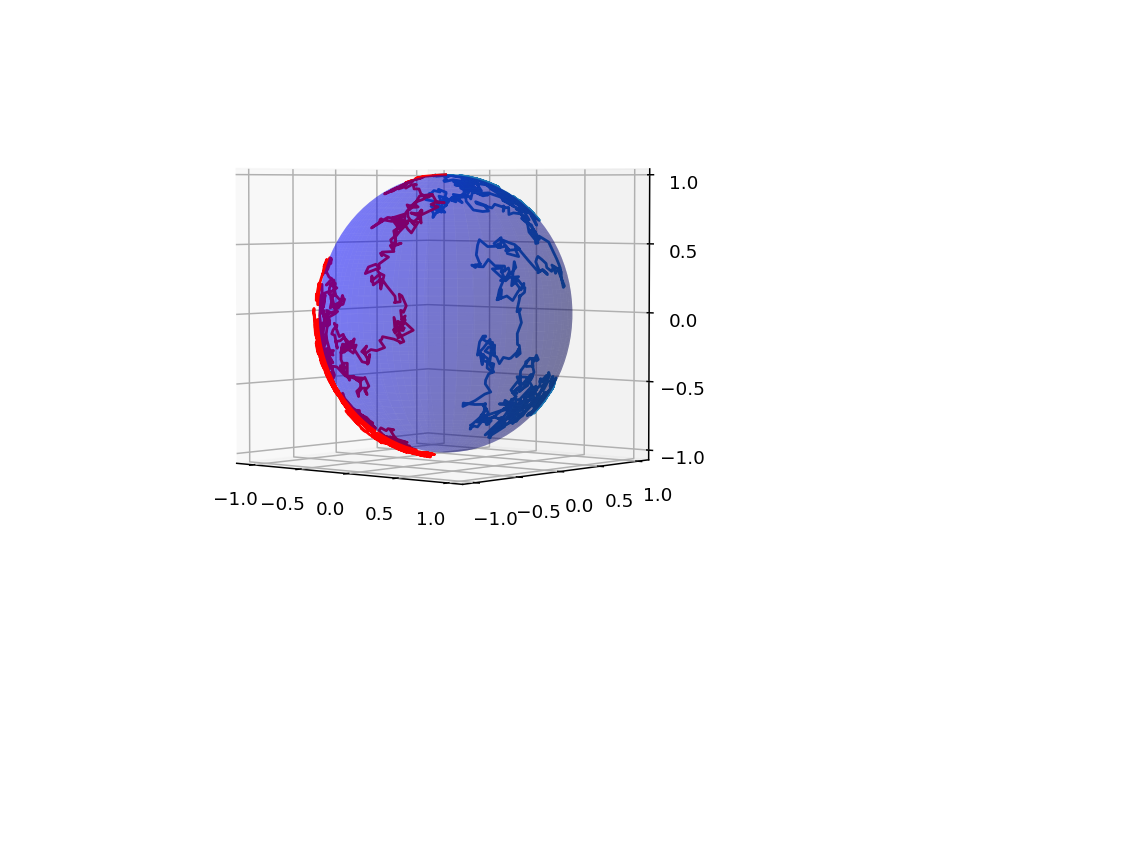

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d',box_aspect=(1,1,1))
draw_sphere(ax)
ax.plot3D(pos_ito[:,0],pos_ito[:,1],pos_ito[:,2])
ax.plot3D(pos_ito_nn[:,0],pos_ito_nn[:,1],pos_ito_nn[:,2],color='red')

The mapback method also works, but check that here if we do not normalize at each step (red curve), the walk drifts away from the unit sphere more rapidly. This is not just a numerical imprecision, it's a feature of the wronlgy integrated Stratonovich SDE (i.e., taking this as an Ito SDE without correction term). It is a striking demonstration of the fact that for $ dn = n \times dW $ to imply $n\cdot dn=0$ requires it to be a Stratonovich SDE, and not an Ito one.

In [23]:
pos_str = mapback_walk(100,0.001)
pos_str_nn = mapback_walk(100,0.001,normalize=False)

<IPython.core.display.Javascript object>


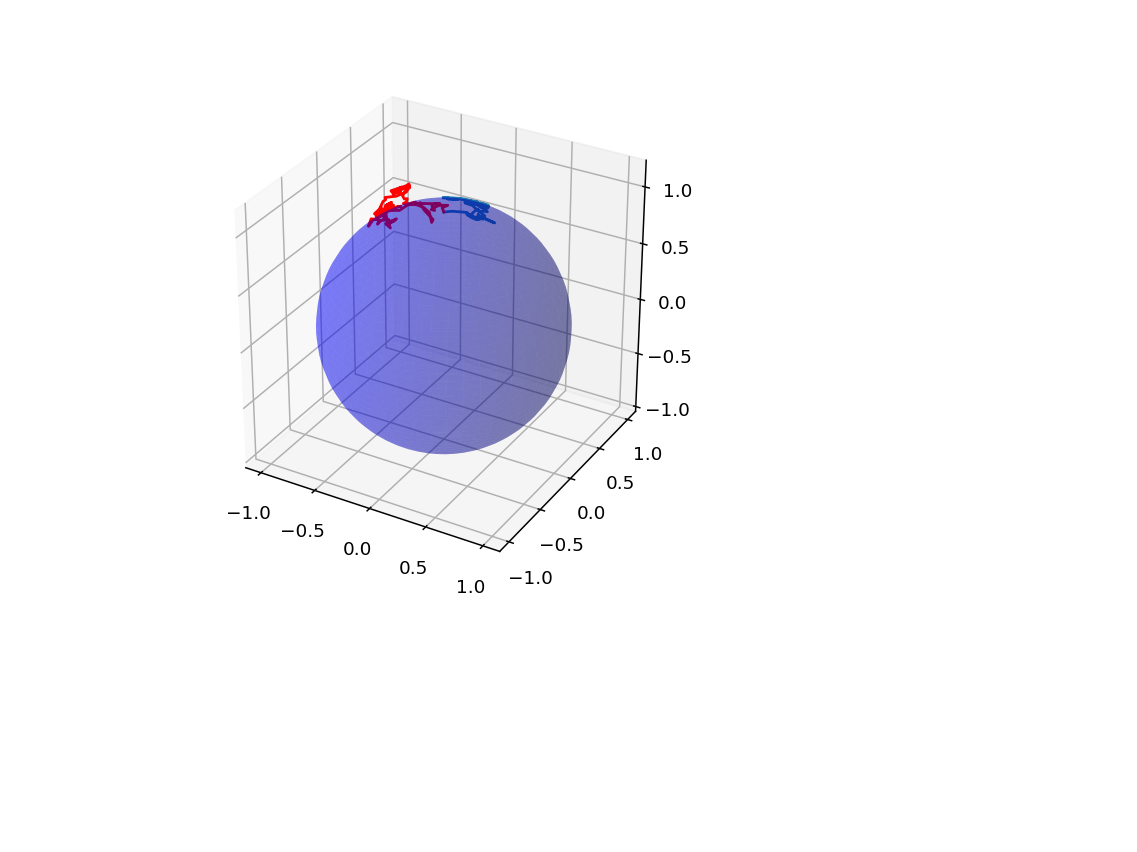

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d',box_aspect=(1,1,1))
draw_sphere(ax)
ax.plot3D(pos_str[:,0],pos_str[:,1],pos_str[:,2])
ax.plot3D(pos_str_nn[:,0],pos_str_nn[:,1],pos_str_nn[:,2],color='red')

Let's plot the norm in the unnormalized versions of the walks, to see more clearly what happens.

<IPython.core.display.Javascript object>


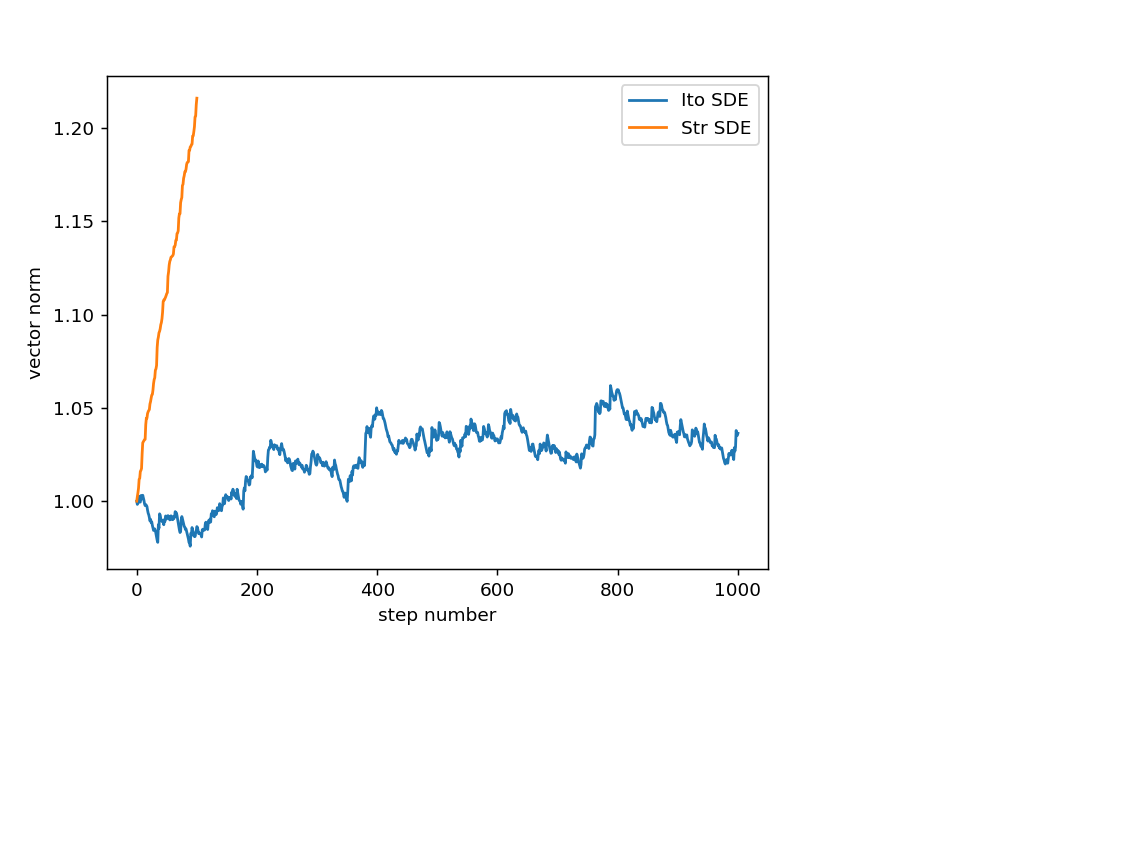

In [25]:
plt.figure()
plt.plot(np.arange(len(pos_ito_nn)),np.linalg.norm(pos_ito_nn,axis=1),label="Ito SDE")
plt.plot(np.arange(len(pos_str_nn)),np.linalg.norm(pos_str_nn,axis=1),label='Str SDE')
plt.ylabel('vector norm')
plt.xlabel('step number')
plt.legend()